In [1]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [2]:
from fake_useragent import UserAgent

ua1 = UserAgent()
randomHeader = {'User-Agent':str(ua1.random)}

Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "c:\program files\python37\lib\urllib\request.py", line 1319, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "c:\program files\python37\lib\http\client.py", line 1252, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "c:\program files\python37\lib\http\client.py", line 1298, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "c:\program files\python37\lib\http\client.py", line 1247, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "c:\program files\python37\lib\http\client.py", line 1026, in _send_output
    self.send(msg)
  File "c:\program files\python37\lib\http\client.py", line 966, in send
    self.connect()
  File "c:\program files\python37\lib\http\client.py", line 938, in connect
    (self.hos

In [3]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, randomHeader, headers = {"Accept-Language": "en-US, en;q=0.5"})

In [4]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [5]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [6]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [7]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [8]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  14,954  12,619  2,143  192',
 'FCT  3,614  2,488  1,084  42',
 'Oyo  2,688  1,451  1,210  27',
 'Edo  2,241  478  1,684  79',
 'Rivers  1,739  277  1,410  52',
 'Kano  1,584  257  1,274  53',
 'Delta  1,486  187  1,257  42',
 'Kaduna  1,396  294  1,090  12',
 'Ogun  1,336  245  1,068  23',
 'Ondo  1,123  552  548  23',
 'Plateau  1,056  568  469  19',
 'Enugu  790  347  425  18',
 'Ebonyi  785  165  596  24',
 'Kwara  753  521  213  19',
 'Katsina  742  262  457  23',
 'Borno  613  17  561  35',
 'Gombe  607  60  524  23',
 'Abia  545  114  426  5',
 'Bauchi  539  8  518  13',
 'Osun  500  260  229  11',
 'Imo  468  340  119  9',
 'Benue  346  282  58  6',
 'Bayelsa  327  29  277  21',
 'Jigawa  322  3  308  11',
 'Nasarawa  312  81  223  8',
 'Niger  223  78  133   12',
 'Akwa Ibom  221  93  121  7',
 'Sokoto  154  1  137  16',
 'Adamawa  140  46  85  9',
 'Anambra  135  48  75  12',
 'Ekiti  132  75  55  2',
 'Kebbi  90  4  79   7',
 'Zamfara  77  1  71  5',
 'Yobe  66  4  5

In [9]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '14,954', '12,619', '2,143', '192'],
 ['FCT', '3,614', '2,488', '1,084', '42'],
 ['Oyo', '2,688', '1,451', '1,210', '27'],
 ['Edo', '2,241', '478', '1,684', '79'],
 ['Rivers', '1,739', '277', '1,410', '52'],
 ['Kano', '1,584', '257', '1,274', '53'],
 ['Delta', '1,486', '187', '1,257', '42'],
 ['Kaduna', '1,396', '294', '1,090', '12'],
 ['Ogun', '1,336', '245', '1,068', '23'],
 ['Ondo', '1,123', '552', '548', '23'],
 ['Plateau', '1,056', '568', '469', '19'],
 ['Enugu', '790', '347', '425', '18'],
 ['Ebonyi', '785', '165', '596', '24'],
 ['Kwara', '753', '521', '213', '19'],
 ['Katsina', '742', '262', '457', '23'],
 ['Borno', '613', '17', '561', '35'],
 ['Gombe', '607', '60', '524', '23'],
 ['Abia', '545', '114', '426', '5'],
 ['Bauchi', '539', '8', '518', '13'],
 ['Osun', '500', '260', '229', '11'],
 ['Imo', '468', '340', '119', '9'],
 ['Benue', '346', '282', '58', '6'],
 ['Bayelsa', '327', '29', '277', '21'],
 ['Jigawa', '322', '3', '308', '11'],
 ['Nasarawa', '312', '81', '

In [10]:
# Locate index position of Akwa Ibom
def get_index(strings, substr):
    for idx, string in enumerate(strings):
        if substr in string:
            break
    return idx

In [11]:
idx = get_index(table_rows, 'Akwa')

In [12]:
# Join 'Akwa' and 'Ibom'
del table_rows[idx][1]
table_rows[idx][0] = 'Akwa Ibom'
table_rows

[['Lagos', '14,954', '12,619', '2,143', '192'],
 ['FCT', '3,614', '2,488', '1,084', '42'],
 ['Oyo', '2,688', '1,451', '1,210', '27'],
 ['Edo', '2,241', '478', '1,684', '79'],
 ['Rivers', '1,739', '277', '1,410', '52'],
 ['Kano', '1,584', '257', '1,274', '53'],
 ['Delta', '1,486', '187', '1,257', '42'],
 ['Kaduna', '1,396', '294', '1,090', '12'],
 ['Ogun', '1,336', '245', '1,068', '23'],
 ['Ondo', '1,123', '552', '548', '23'],
 ['Plateau', '1,056', '568', '469', '19'],
 ['Enugu', '790', '347', '425', '18'],
 ['Ebonyi', '785', '165', '596', '24'],
 ['Kwara', '753', '521', '213', '19'],
 ['Katsina', '742', '262', '457', '23'],
 ['Borno', '613', '17', '561', '35'],
 ['Gombe', '607', '60', '524', '23'],
 ['Abia', '545', '114', '426', '5'],
 ['Bauchi', '539', '8', '518', '13'],
 ['Osun', '500', '260', '229', '11'],
 ['Imo', '468', '340', '119', '9'],
 ['Benue', '346', '282', '58', '6'],
 ['Bayelsa', '327', '29', '277', '21'],
 ['Jigawa', '322', '3', '308', '11'],
 ['Nasarawa', '312', '81', '

In [13]:
idx = get_index(table_rows, 'Cross')

In [14]:
# Join 'Cross' and 'River'
del table_rows[idx][1]
table_rows[idx][0] = 'Cross River'
table_rows

[['Lagos', '14,954', '12,619', '2,143', '192'],
 ['FCT', '3,614', '2,488', '1,084', '42'],
 ['Oyo', '2,688', '1,451', '1,210', '27'],
 ['Edo', '2,241', '478', '1,684', '79'],
 ['Rivers', '1,739', '277', '1,410', '52'],
 ['Kano', '1,584', '257', '1,274', '53'],
 ['Delta', '1,486', '187', '1,257', '42'],
 ['Kaduna', '1,396', '294', '1,090', '12'],
 ['Ogun', '1,336', '245', '1,068', '23'],
 ['Ondo', '1,123', '552', '548', '23'],
 ['Plateau', '1,056', '568', '469', '19'],
 ['Enugu', '790', '347', '425', '18'],
 ['Ebonyi', '785', '165', '596', '24'],
 ['Kwara', '753', '521', '213', '19'],
 ['Katsina', '742', '262', '457', '23'],
 ['Borno', '613', '17', '561', '35'],
 ['Gombe', '607', '60', '524', '23'],
 ['Abia', '545', '114', '426', '5'],
 ['Bauchi', '539', '8', '518', '13'],
 ['Osun', '500', '260', '229', '11'],
 ['Imo', '468', '340', '119', '9'],
 ['Benue', '346', '282', '58', '6'],
 ['Bayelsa', '327', '29', '277', '21'],
 ['Jigawa', '322', '3', '308', '11'],
 ['Nasarawa', '312', '81', '

In [15]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"14,954","12,619","2,143",192
1,FCT,"3,614","2,488","1,084",42
2,Oyo,"2,688","1,451","1,210",27
3,Edo,"2,241",478,"1,684",79
4,Rivers,"1,739",277,"1,410",52


In [16]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"14,954","12,619","2,143",192
1,FCT,"3,614","2,488","1,084",42
2,Oyo,"2,688","1,451","1,210",27
3,Edo,"2,241",478,"1,684",79
4,Rivers,"1,739",277,"1,410",52


In [17]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [18]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [19]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [20]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [21]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [22]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,14954,12619,2143,192
1,Federal Capital Territory,3614,2488,1084,42
2,Oyo,2688,1451,1210,27


In [23]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [24]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [25]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [26]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [27]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [28]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [29]:
shapefile.columns = ['States', 'geometry']

In [30]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [31]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [32]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (37, 6))

In [33]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",545,114,426,5
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",140,46,85,9


In [34]:
# Define plot function
def visual(data, hue, cmap):
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'label':'Counts', 'fraction':0.036, 'pad':0, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], color='black', fontsize=13, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue.lower()), dpi=150)

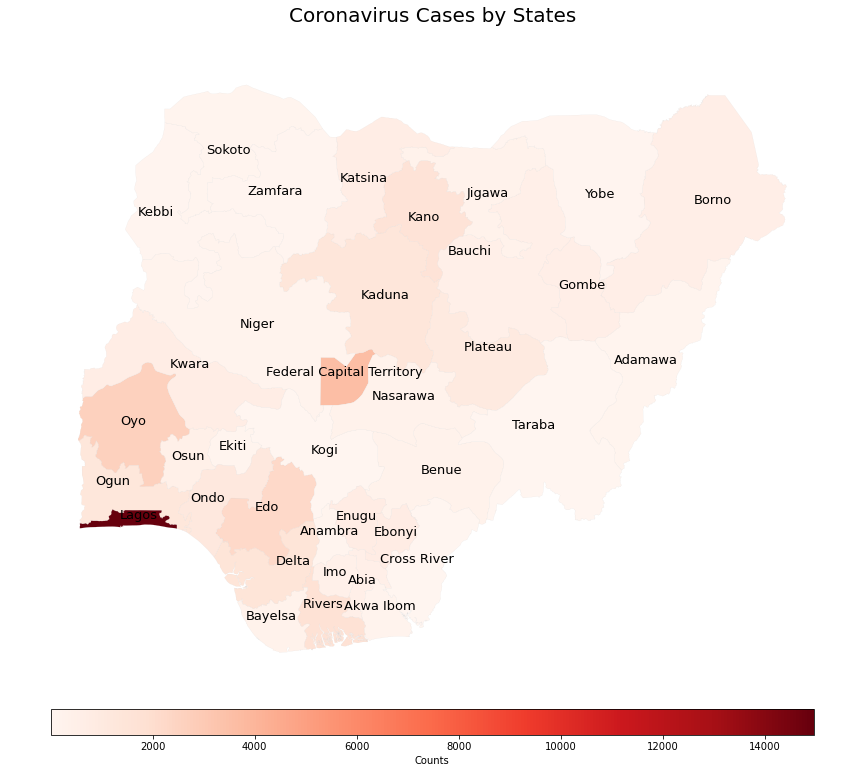

In [35]:
# Plot geomap for cases
visual(data, 'Cases', 'Reds')

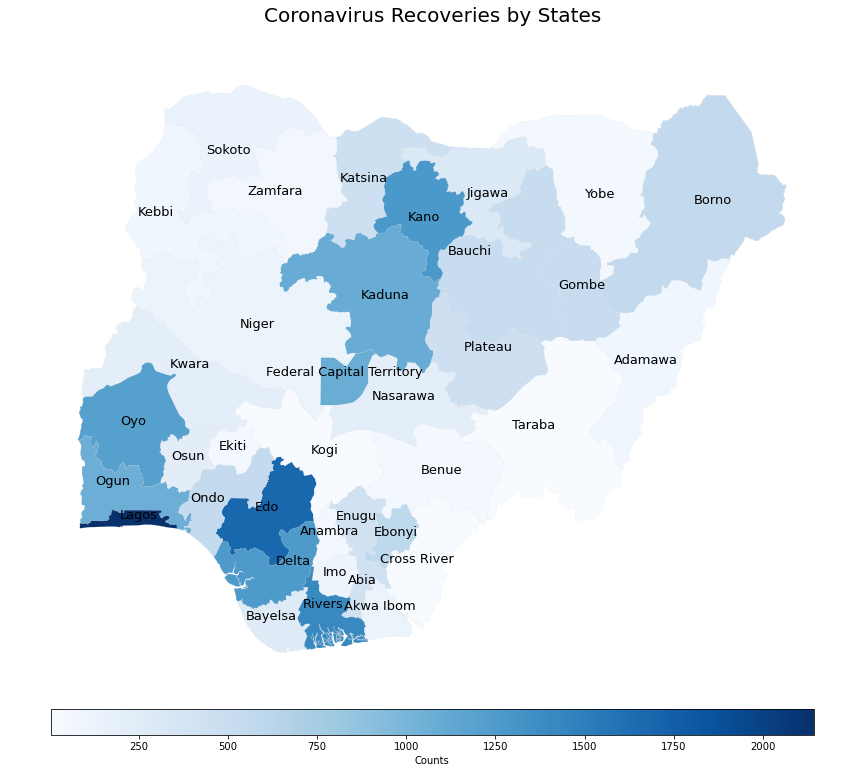

In [36]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'Blues')

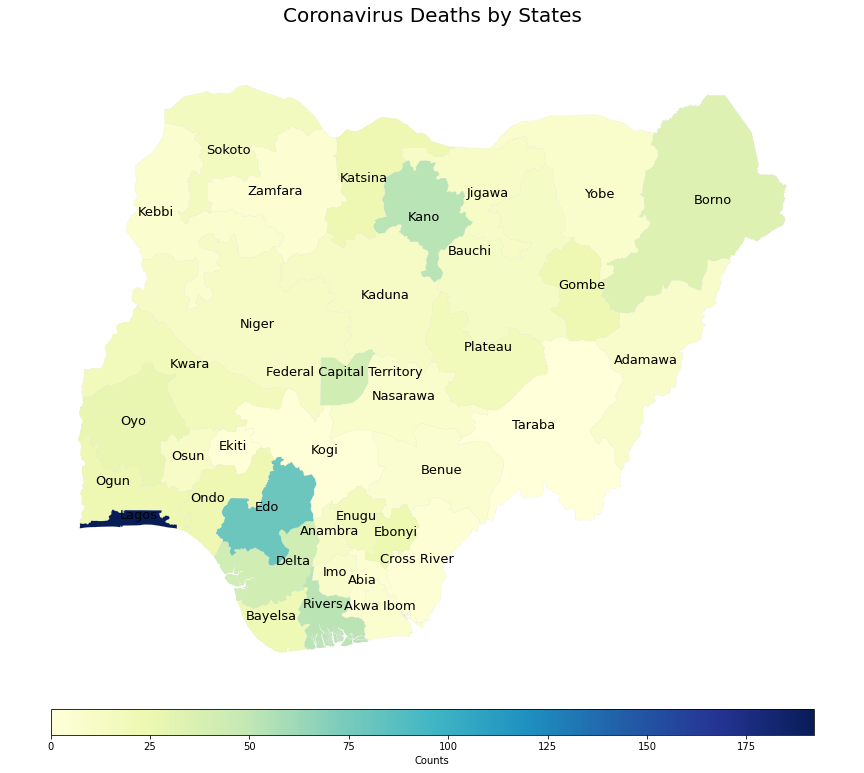

In [37]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu')

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [38]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [39]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [40]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [41]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [42]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']
df_cases = df_cases.loc['2/28/20':]

In [43]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']
df_recovs = df_recovs.loc['2/28/20':]

In [44]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']
df_deaths = df_deaths.loc['2/28/20':]

In [45]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [46]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [47]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [48]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [49]:
time_series = time_series.asfreq('D', method = 'ffill')

In [50]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-02-28,1,0,0
2020-02-29,1,0,0
2020-03-01,1,0,0
2020-03-02,1,0,0
2020-03-03,1,0,0


In [51]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [52]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

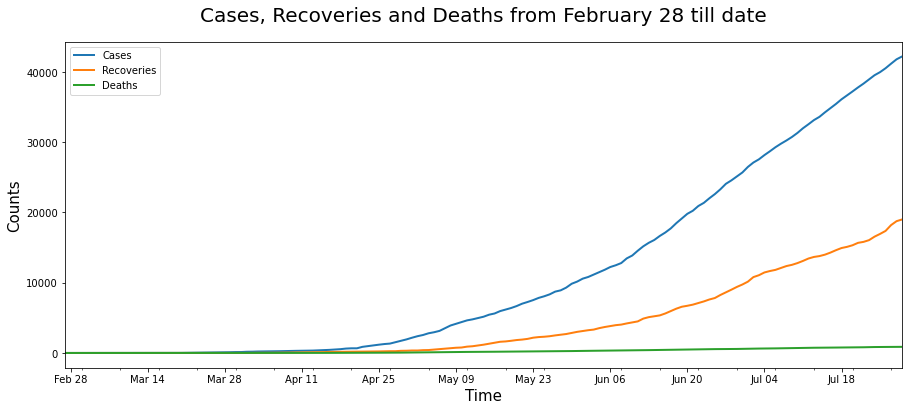

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))
time_series.plot(linewidth=2, ax=ax)
ax.set_title('Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('line-plot.png', dpi=150)

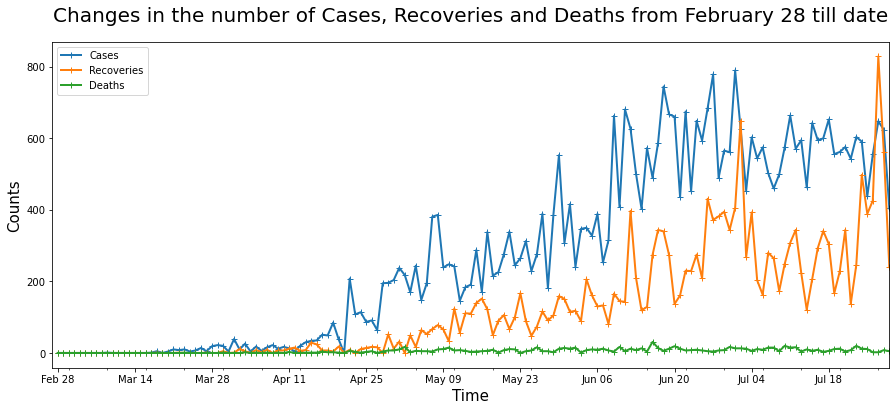

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))
time_series.diff().plot(ax=ax, linewidth=2, marker='+')
ax.set_title('Changes in the number of Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])
ax.legend(loc='upper left')
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('time-lag.png', dpi=150)